In [71]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [72]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [73]:
#Set random seed
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [74]:
image_size = (224, 224) 
batch_size = 32 
train_dir = 'src/../input/brain-tumor-classification-mri/Training' 
test_dir = 'src/../input/brain-tumor-classification-mri/Testing' 

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred', # detect classes from input folder
    label_mode='categorical', # One-hot encoding
    image_size=image_size, # Resize images
    interpolation='bicubic', # Resize method
    batch_size=batch_size,
    shuffle=True, # Shuffle the data
    seed=42
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    interpolation='bicubic',
    batch_size=batch_size,
    shuffle=True,
    seed=42 
)

# Optimize loading the dataset
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)



Found 2870 files belonging to 4 classes.
Found 394 files belonging to 4 classes.


In [75]:
X_list = []
y_list = []

for image_batch, label_batch in train_dataset:
    X_list.append(image_batch.numpy())
    y_list.append(label_batch.numpy())

for image_batch, label_batch in test_dataset:
    X_list.append(image_batch.numpy())
    y_list.append(label_batch.numpy()) 

#Conver batches into np arrays
X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)

X, y = shuffle(X, y, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2872, 224, 224, 3)
y_train shape: (2872, 4)
X_test shape: (392, 224, 224, 3)
y_test shape: (392, 4)


In [76]:
#Transfer learning with ResNet101
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [77]:
#Build CNN model with Keras functional API 
model = base_model.output
model = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling2d')(model)
model = tf.keras.layers.Dropout(rate=0.3)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=base_model.input, outputs = model)

#Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# model.summary()

In [78]:
X_train_CNN = preprocess_input(X_train.astype(np.float32))
history = model.fit(X_train_CNN, y_train, epochs=20, batch_size=batch_size, validation_split=0.1)

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 25s 180ms/step - accuracy: 0.4892 - loss: 1.2514 - val_accuracy: 0.7847 - val_loss: 0.5783
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.7407 - loss: 0.6535 - val_accuracy: 0.8090 - val_loss: 0.5309
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.7974 - loss: 0.5199 - val_accuracy: 0.8299 - val_loss: 0.4947
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.8145 - loss: 0.4657 - val_accuracy: 0.8403 - val_loss: 0.4270
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.8322 - loss: 0.4442 - val_accuracy: 0.8368 - val_loss: 0.4338
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - accuracy: 0.8576 - loss: 0.3818 - val_accuracy: 0.8403 - val_loss: 0.4174
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.8684 - loss: 0.3616 - val_accuracy: 0.8542 - val_loss: 0.3829
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.8715 - loss: 0.3360 - val_accuracy: 0.8507 

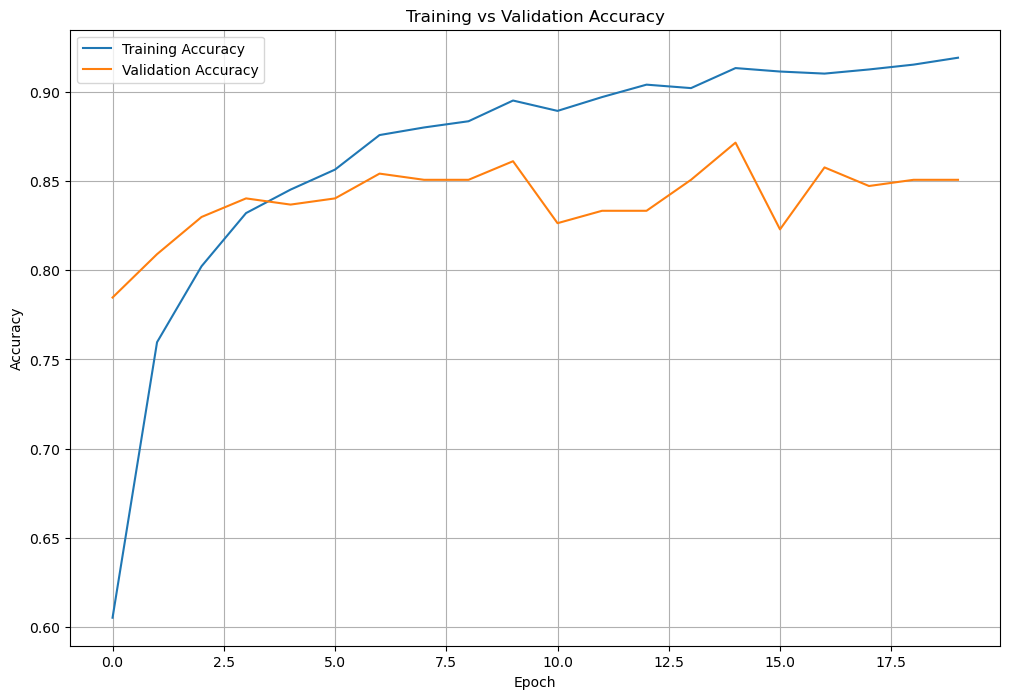

In [79]:
#Plot the accuracy on training and validation set (before fine-tuning)

plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [80]:
#Fine-tuning the pre-trained model
base_model.trainable = True

#Unfreeze only 40 last layers of the pre-trained model
for layer in base_model.layers[:-40]:
    layer.trainable = False

#Recompile the main model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#For callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint('CNN_model.keras', monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_delta=0.001,
                              min_lr=1e-6, mode='auto', verbose=1)

#Train the model with callbacks
history = model.fit(X_train_CNN, y_train, epochs=12, batch_size=batch_size, validation_split=0.1, callbacks=[tensorboard, checkpoint, reduce_lr, early_stop])

Epoch 1/12
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8476 - loss: 0.4540
Epoch 1: val_accuracy improved from -inf to 0.91319, saving model to CNN_model.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 36s 254ms/step - accuracy: 0.8480 - loss: 0.4529 - val_accuracy: 0.9132 - val_loss: 0.2897 - learning_rate: 1.0000e-04
Epoch 2/12
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9771 - loss: 0.0654
Epoch 2: val_accuracy did not improve from 0.91319
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.9771 - loss: 0.0653 - val_accuracy: 0.9097 - val_loss: 0.2938 - learning_rate: 1.0000e-04
Epoch 3/12
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9938 - loss: 0.0243
Epoch 3: val_accuracy improved from 0.91319 to 0.94792, saving model to CNN_model.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9938 - loss: 0.0242 - val_accuracy: 0.9479 - val_loss: 0.1812 - learning_rate: 1.0000e-04
Epoch 4/12
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9957 - loss: 0

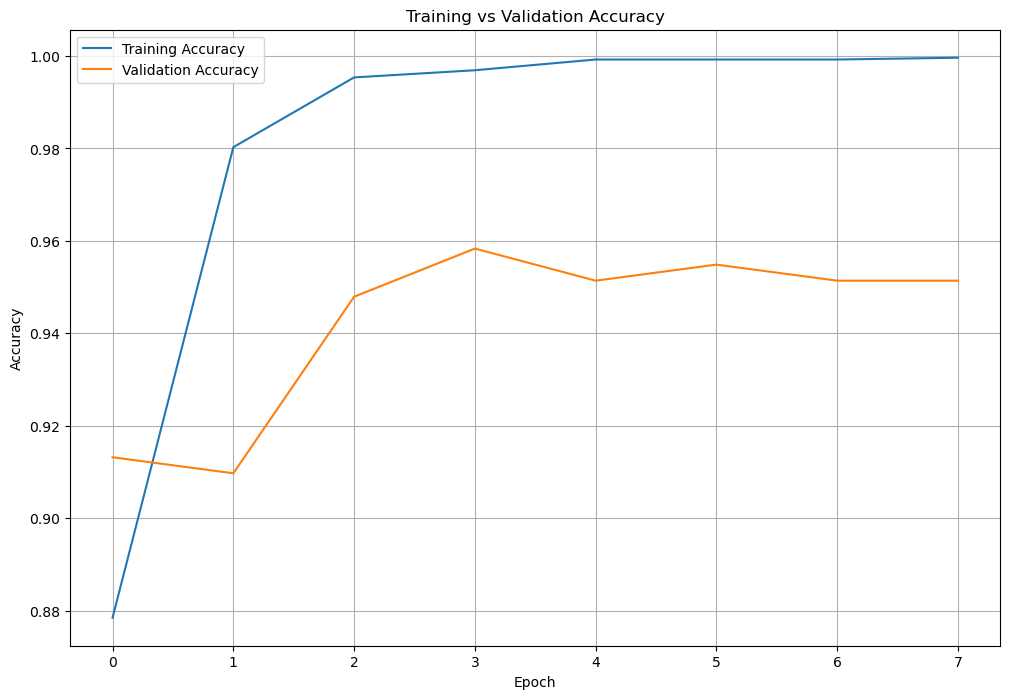

In [81]:
#Plot the accuracy on training and validation set (after fine-tuning)
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [82]:
X_test_CNN = preprocess_input(X_test.astype(np.float32))
#Perfrom prediction
y_pred = model.predict(X_test_CNN)

#Convert the highest probability to corresponding class label (index)
y_test_label = np.argmax(y_test, axis=1)
y_pred_label = np.argmax(y_pred, axis=1)

class_labels = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

#Compare to true labels
print(classification_report(y_test_label, y_pred_label, target_names=class_labels))

#Report accuracy and 
loss, accuracy = model.evaluate(X_test_CNN, y_test, verbose = 2)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Loss: {loss:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 449ms/step
              precision    recall  f1-score   support

      glioma       0.98      0.93      0.95       109
  meningioma       0.93      0.97      0.95       105
    no_tumor       0.97      0.98      0.98        60
   pituitary       0.99      0.99      0.99       118

    accuracy                           0.97       392
   macro avg       0.97      0.97      0.97       392
weighted avg       0.97      0.97      0.97       392

13/13 - 7s - 501ms/step - accuracy: 0.9668 - loss: 0.1322
Accuracy: 96.68%
Loss: 0.1322


In [83]:
def plot_confustion_matrix(actual, predicted, title):
    plt.figure(figsize=(12, 8))
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(title)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()

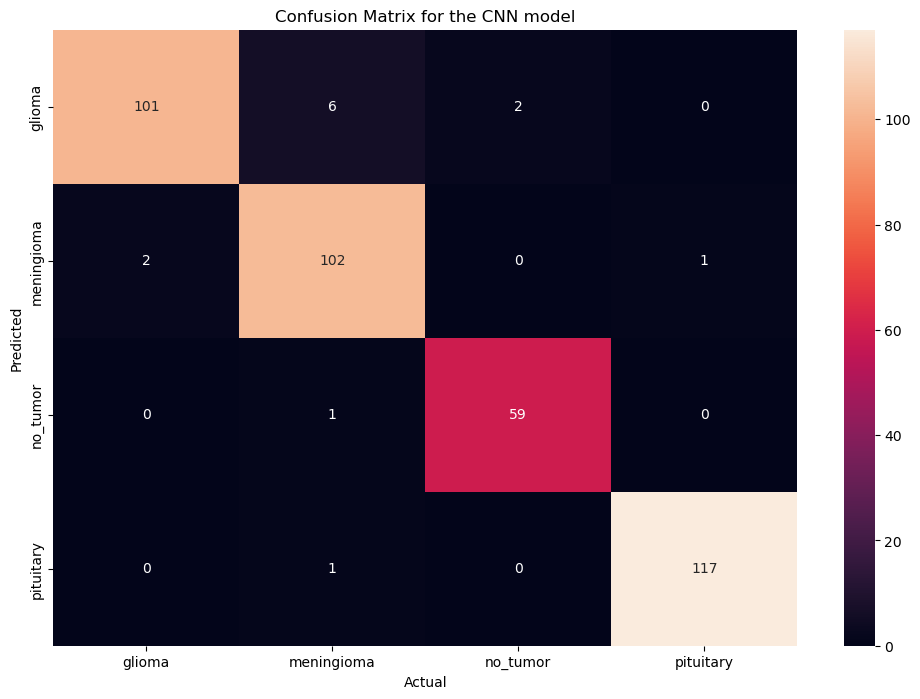

In [84]:
plot_confustion_matrix(actual=y_test_label, predicted=y_pred_label, title='Confusion Matrix for the CNN model')

In [85]:
#Retrieve the output of the GlobalAvgPool2D layer, which serves as the input for the final Dense layer
features_extractor = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('global_average_pooling2d').output)

#Extract features from input images. These features will be used to train and test on other models
X_train = features_extractor.predict(X_train_CNN)
X_test = features_extractor.predict(X_test_CNN)

#One-hot encoded to index label
y_train_label = np.argmax(y_train, axis=1)
y_test_label = np.argmax(y_test, axis=1)

#Standardize input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape)
print(X_test_scaled.shape)
print(y_train_label.shape)
print(y_test_label.shape)

90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step
(2872, 2048)
(392, 2048)
(2872,)
(392,)


In [86]:
#Hyper-parameter tuning
SVM_model = SVC(probability=True)
param_grid = {
    'kernel': ['rbf', 'linear', 'poly'],
    'C': [0.1, 1, 10],
    'gamma': ['scale'],
}

In [87]:
grid = GridSearchCV(estimator=SVM_model, param_grid=param_grid, n_jobs=-1, cv=4)
grid.fit(X_train_scaled, y_train_label)

# Print the best hyperparameters
print("Best parameters: ", grid.best_params_)
print("Best accuracy: {:.2f}%".format(grid.best_score_ * 100))

Best parameters:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best accuracy: 99.09%


              precision    recall  f1-score   support

      glioma       0.98      0.91      0.94       109
  meningioma       0.89      0.97      0.93       105
    no_tumor       0.98      0.97      0.97        60
   pituitary       0.98      0.98      0.98       118

    accuracy                           0.96       392
   macro avg       0.96      0.96      0.96       392
weighted avg       0.96      0.96      0.96       392

Accuracy: 95.66%


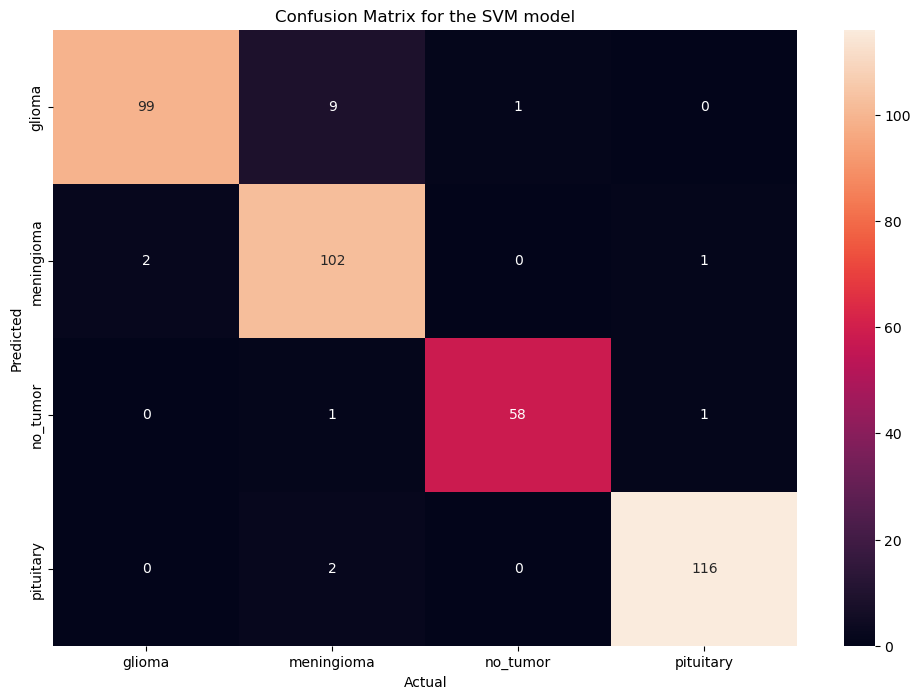

In [88]:
#Perform prediction with SVM model
SVM_model = grid.best_estimator_
y_pred_label = SVM_model.predict(X_test_scaled)

#Compare to true labels
print(classification_report(y_test_label, y_pred_label, target_names=class_labels))

#Calculate the accuracy
accuracy = accuracy_score(y_test_label, y_pred_label)
print(f"Accuracy: {accuracy * 100:.2f}%")

#Plot the confusion matrix
plot_confustion_matrix(actual=y_test_label, predicted=y_pred_label, title='Confusion Matrix for the SVM model')

In [89]:
RF_model = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grid = {
    'n_estimators': [100, 200],
    'criterion': ['gini'],
    'max_depth': [None, 15],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5],
    'bootstrap': [True, False]
}

In [90]:
grid = GridSearchCV(estimator=RF_model, param_grid=param_grid, n_jobs=-1, cv=4)
grid.fit(X_train_scaled, y_train_label)

# Print the best hyperparameters
print("Best parameters: ", grid.best_params_)
print("Best accuracy: {:.2f}%".format(grid.best_score_ * 100))

Best parameters:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best accuracy: 97.25%


              precision    recall  f1-score   support

      glioma       0.98      0.89      0.93       109
  meningioma       0.87      0.98      0.92       105
    no_tumor       1.00      0.93      0.97        60
   pituitary       0.97      0.98      0.98       118

    accuracy                           0.95       392
   macro avg       0.96      0.95      0.95       392
weighted avg       0.95      0.95      0.95       392

Accuracy: 94.90%


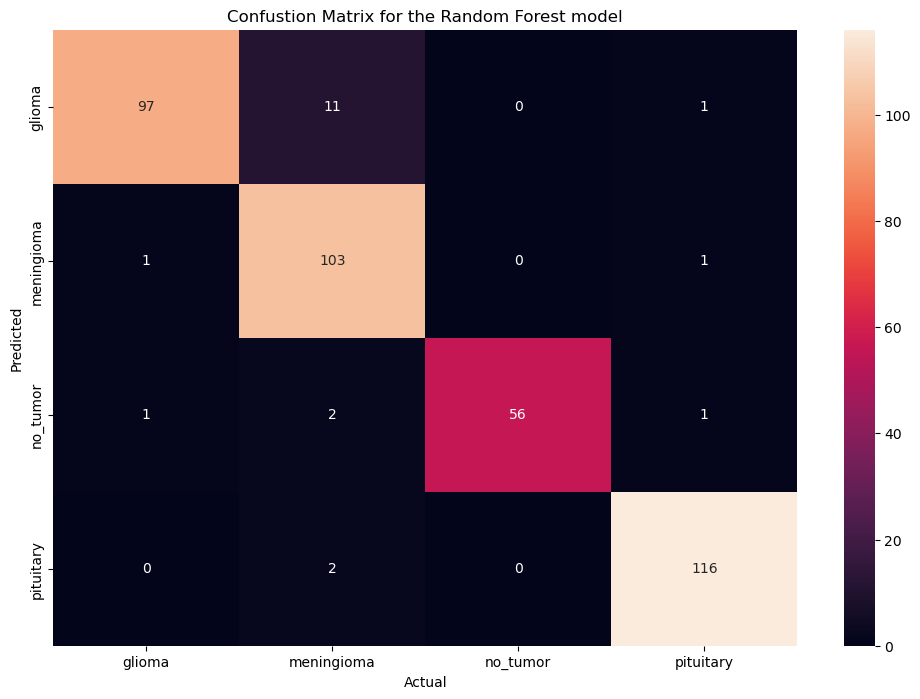

In [91]:
#Perform prediction with Random Forest model
RF_model = grid.best_estimator_
y_pred_label = RF_model.predict(X_test_scaled)

#Compare to true labels
print(classification_report(y_test_label, y_pred_label, target_names=class_labels))

#Calculate the accuracy
accuracy = accuracy_score(y_test_label, y_pred_label)
print(f"Accuracy: {accuracy * 100:.2f}%")

#Plot the confusion matrix
plot_confustion_matrix(actual=y_test_label, predicted=y_pred_label, title='Confustion Matrix for the Random Forest model')